In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows',None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb
import catboost as ctb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import imblearn
from imblearn.over_sampling import SMOTE

import eli5  
from tqdm import tqdm

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from sklearn.metrics import fbeta_score, precision_score, recall_score, f1_score

In [2]:
df_train = pd.read_hdf("../input/train_churn_pred.h5")
df_test = pd.read_hdf("../input/test_churn_pred.h5")
df_train.shape, df_test.shape

((34999, 171), (35000, 170))

In [3]:
df = pd.concat([df_train,df_test])

df.shape

(69999, 171)

In [4]:
(df.id.value_counts() > 1).sum()

0

In [5]:
unique_cols = []
for col in df.columns: 
    if df[col].value_counts().shape[0]==1: 
        unique_cols.append(col)
print(unique_cols)

['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [6]:
df.drop(unique_cols, axis=1, inplace= True )

In [7]:
df.shape

(69999, 159)

In [8]:
def check_missing(df): 
    return round(df.isnull().sum()/df.shape[0]*100,2).sort_values(ascending= False )

In [9]:
check_missing(df)

av_rech_amt_data_6          74.9
count_rech_2g_6             74.9
date_of_last_rech_data_6    74.9
arpu_3g_6                   74.9
arpu_2g_6                   74.9
                            ... 
max_rech_amt_8               0.0
last_day_rch_amt_6           0.0
last_day_rch_amt_7           0.0
last_day_rch_amt_8           0.0
id                           0.0
Length: 159, dtype: float64

In [10]:
dff = df.dropna(thresh=df.shape[0]*0.50,how='all',axis=1)

In [11]:
feats_drop = (set(df.columns)-set(dff.columns))
feats_drop = [x for x in feats_drop if x != 'churn_probability']

In [12]:
df.drop(feats_drop, axis = 1, inplace= True)

In [13]:
df.shape

(69999, 129)

In [14]:
def get_features(df):
    numerical_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[np.object])
    return numerical_features, categorical_features

def get_missing(df):
    missing = df.isna().sum().sort_values(ascending=False)
    missing = missing[missing != 0]
    missing_perc = missing/df.shape[0]*100
    return missing, missing_perc

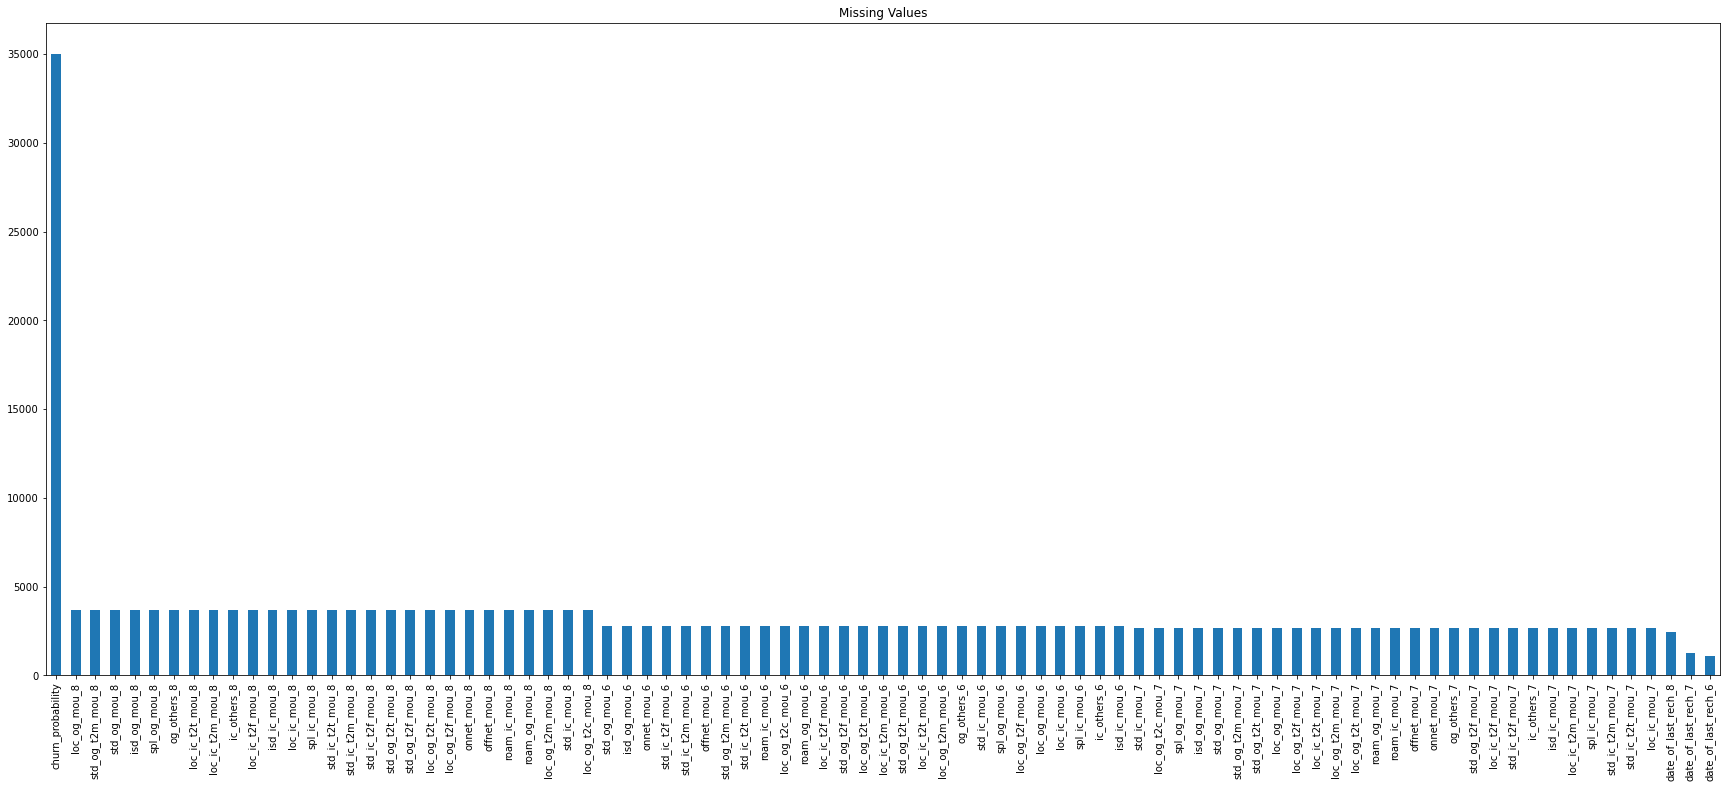

In [15]:
## plot missing 

missing, missing_perc = get_missing(df)
missing.plot(kind='bar',figsize=(30,12))
plt.title('Missing Values')
plt.show()

In [16]:
pd.concat([missing, missing_perc], axis=1, keys=['Total','Percent']).T

,churn_probability,loc_og_mou_8,std_og_t2m_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,ic_others_8,loc_ic_t2f_mou_8,isd_ic_mou_8,loc_ic_mou_8,spl_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_og_t2t_mou_8,std_og_t2f_mou_8,loc_og_t2t_mou_8,loc_og_t2f_mou_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2m_mou_8,std_ic_mou_8,loc_og_t2c_mou_8,std_og_mou_6,isd_og_mou_6,onnet_mou_6,std_ic_t2f_mou_6,std_ic_t2m_mou_6,offnet_mou_6,std_og_t2m_mou_6,std_ic_t2t_mou_6,roam_ic_mou_6,loc_og_t2c_mou_6,roam_og_mou_6,loc_ic_t2f_mou_6,std_og_t2f_mou_6,loc_og_t2t_mou_6,loc_ic_t2m_mou_6,std_og_t2t_mou_6,loc_ic_t2t_mou_6,loc_og_t2m_mou_6,og_others_6,std_ic_mou_6,spl_og_mou_6,loc_og_t2f_mou_6,loc_og_mou_6,loc_ic_mou_6,spl_ic_mou_6,ic_others_6,isd_ic_mou_6,std_ic_mou_7,loc_og_t2c_mou_7,spl_og_mou_7,isd_og_mou_7,std_og_mou_7,std_og_t2m_mou_7,std_og_t2t_mou_7,loc_og_mou_7,loc_og_t2f_mou_7,loc_ic_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2t_mou_7,roam_og_mou_7,roam_ic_mou_7,offnet_mou_7,onnet_mou_7,og_others_7,std_og_t2f_mou_7,loc_ic_t2f_mou_7,std_ic_t2f_mou_7,ic_others_7,isd_ic_mou_7,loc_ic_t2m_mou_7,spl_ic_mou_7,std_ic_t2m_mou_7,std_ic_t2t_mou_7,loc_ic_mou_7,date_of_last_rech_8,date_of_last_rech_7,date_of_last_rech_6
Total,35000.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2461.000000,1234.000000,1101.00000
Percent,50.000714,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,5.290076,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.954342,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.838626,3.515765,1.762882,1.57288


In [17]:
numerical_features, categorical_features = get_features(df) 

In [18]:
black_list_missing = ['churn_probability','date_of_last_rech_8', 'date_of_last_rech_7', 'date_of_last_rech_6']
colsToMedian = [x for x in missing.index if x not in black_list_missing]

for col in colsToMedian:
    df.loc[df[col].isna(), col] = df[col].median()

In [19]:
df[categorical_features.columns]= df[categorical_features.columns].apply(lambda x : pd.to_datetime(x))

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 3 to 69996
Columns: 129 entries, id to churn_probability
dtypes: datetime64[ns](3), float16(4), float32(95), float64(1), int16(10), int32(3), int64(1), int8(12)
memory usage: 32.0 MB


In [21]:
df.columns[df.isna().sum()>0]

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'churn_probability'],
      dtype='object')

### Wizualizacja Danych

In [22]:
plt.figure(figsize=(27,60)) 
for v,n in enumerate(neg_corr): 
    plt.subplot(15,4,(v+1)) 
    sns.boxplot(data = df, x = 'churn_probability', y = neg_corr[v] , showfliers=False)
    plt.xlabel(n,fontsize=10) 

NameError: name 'neg_corr' is not defined

<Figure size 1944x4320 with 0 Axes>

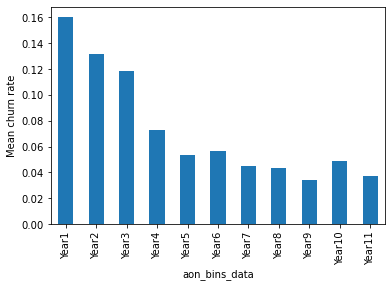

In [23]:
aon_bins = [0, 365, 730, 1095, 1460, 1825, 2190, 2555, 2920, 3285, 3650, 5015]
bucket_l = ["Year"+str(x) for x in range(1,12)]
df['aon_bins_data'] = pd.cut(df.aon, aon_bins, labels=bucket_l)

df.groupby('aon_bins_data').churn_probability.mean().plot.bar()
plt.ylabel('Mean churn rate')
plt.show()

df.drop('aon_bins_data', axis = 1, inplace= True )

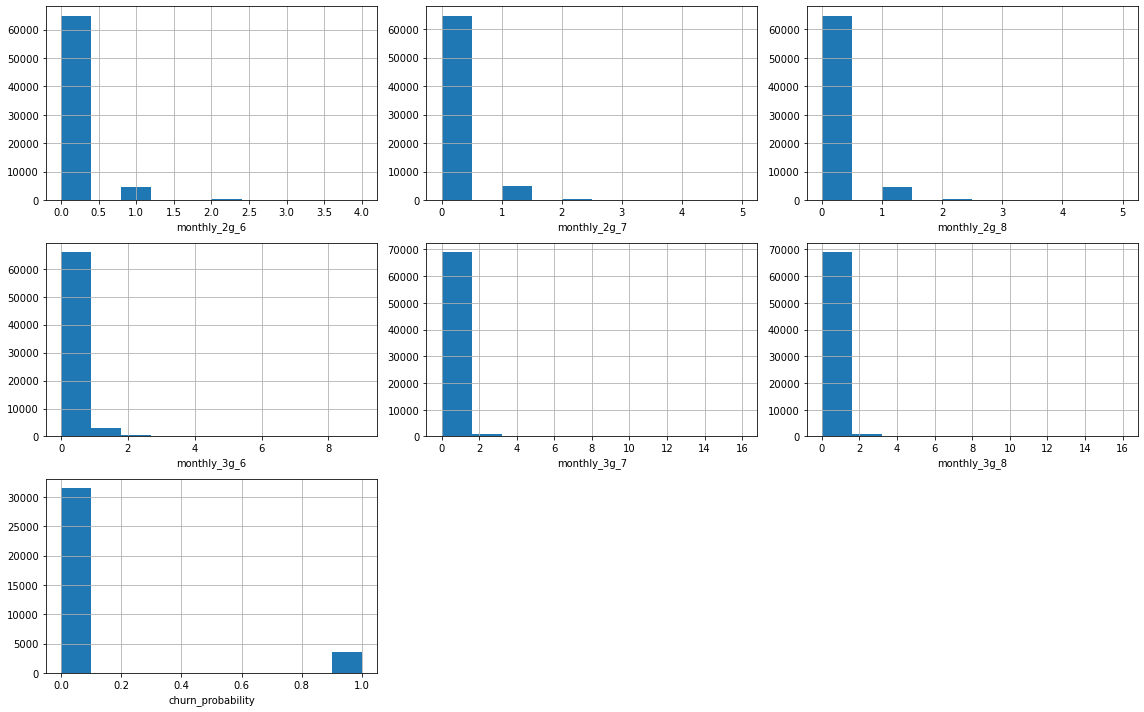

In [24]:
cat_features = ['monthly_2g_6','monthly_2g_7','monthly_2g_8','monthly_3g_6','monthly_3g_7',
                'monthly_3g_8', 'churn_probability']
fig = plt.figure(figsize=(16,10))
for i in range(len(cat_features)):
    fig.add_subplot(3, 3, i+1)
    df[cat_features].iloc[:,i].hist()
    plt.xlabel(df[cat_features].columns[i])
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='churn_probability', ylabel='value'>

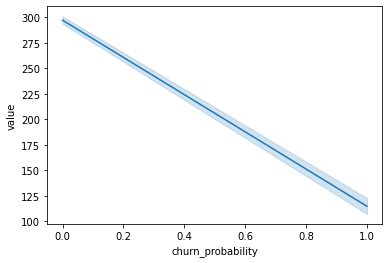

In [25]:
df_melt = pd.melt(df[['arpu_8', 'churn_probability']], id_vars = 'churn_probability')
sns.lineplot(x = 'churn_probability' , y = 'value',  data = df_melt)

### Usuwanie Outlier

In [26]:
df.describe(percentiles=[.25,.5,.75,.90,.95,.99]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
id,69999.0,34999.000000,20207.115084,0.000000,17499.500000,34999.000000,52498.500000,62998.200000,66498.100000,69298.020000,69998.000000
arpu_6,69999.0,283.134369,334.213898,-2258.708984,93.581001,197.483994,370.791000,619.993787,832.022717,1400.276687,27731.087891
arpu_7,69999.0,278.185913,344.366913,-1289.714966,86.714001,191.587997,365.369507,615.661414,823.236700,1414.891360,35145.835938
arpu_8,69999.0,278.858826,351.924316,-945.807983,84.095001,192.233994,369.908997,614.994617,828.464709,1445.054768,33543.625000
onnet_mou_6,69999.0,129.236755,294.605408,0.000000,8.060000,34.110001,113.099998,331.766010,598.600024,1429.040439,7376.709961
...,...,...,...,...,...,...,...,...,...,...,...
aon,69999.0,1220.639709,952.426321,180.000000,468.000000,868.000000,1813.000000,2792.000000,3108.000000,3651.000000,4337.000000
aug_vbc_3g,69999.0,68.108597,269.328644,0.000000,0.000000,0.000000,0.000000,160.444003,464.277011,1226.659795,12916.219727
jul_vbc_3g,69999.0,65.935829,267.899017,0.000000,0.000000,0.000000,0.000000,136.272003,446.352997,1254.279019,9165.599609
jun_vbc_3g,69999.0,60.076736,257.226807,0.000000,0.000000,0.000000,0.000000,110.328000,400.134006,1188.267800,11166.209961


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


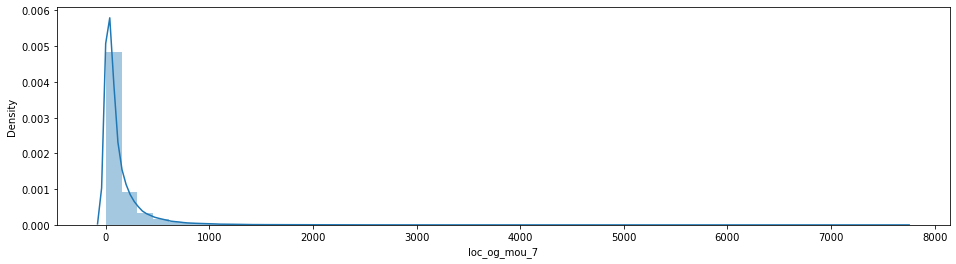

In [27]:
plt.figure(figsize=(16,4))
sns.distplot(df.loc_og_mou_7)
plt.show()

In [28]:
df['loc_og_mou_7'].describe()

count    69999.000000
mean       137.782089
std        241.995697
min          0.000000
25%         18.950000
50%         63.430000
75%        157.740005
max       7674.779785
Name: loc_og_mou_7, dtype: float64

In [29]:
black_list = ['id', 'churn_probability', 'arpu_6', 'arpu_7', 'arpu_8']
feats = [x for x in numerical_features if x not in black_list]
skewed_features = df[feats].apply(lambda x: x.skew()).sort_values(ascending=False)

In [ ]:
skewed_features

In [30]:
for feat in skewed_features.index:
    # features which are more than 50% skewed are transformed
    if skewed_features.loc[feat] > 0.5:
        df[feat] = np.log1p(df[feat])

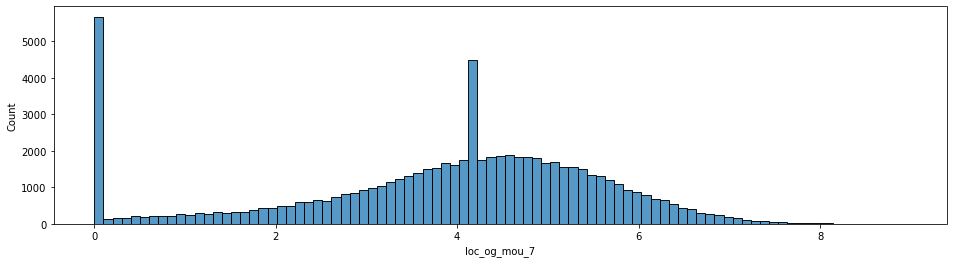

In [31]:
plt.figure(figsize=(16,4))
sns.histplot(df.loc_og_mou_7)
plt.show()

### Add new feats

In [32]:
date_cols = df.select_dtypes('datetime')

In [33]:
cols_6_mon = [] 
cols_7_mon = [] 
cols_8_mon = []
for col in set(df)- set(date_cols): 
    if col[-1]=='6': 
        cols_6_mon.append(col) 
        
for col in set(df)-set(date_cols): 
    if col [-1]=='7': 
        cols_7_mon.append(col) 
        
for col in set(df)-set(date_cols): 
    if col[-1]=='8': 
        cols_8_mon.append(col) 
    
#sorting the columns
cols_6_mon = sorted(cols_6_mon)
cols_7_mon = sorted(cols_7_mon)
cols_8_mon = sorted(cols_8_mon)
desc = []
mean_6_7 = []
#getting the average values for the months of June and July and appending their means
for col6,col7 in zip(cols_6_mon,cols_7_mon):
    desc.append(col6[:-1])
    mean_6_7.append(((df[col6] + df[col7])/2).mean())
    
#appending the means of different columns of august
col8_val = []
for col8 in cols_8_mon:
    col8_val.append(df[col8].mean())
#preparing the dataframe to display the statistics for good phase and actions phase
monthly_stats_df = pd.DataFrame(data={'desc':desc,'mean_6_7':mean_6_7,'col8_val':col8_val})
monthly_stats_df['val_diff']= monthly_stats_df['col8_val'] - monthly_stats_df['mean_6_7']
monthly_stats_df['percentage_diff']=(monthly_stats_df['col8_val']-monthly_stats_df['mean_6_7']
                                    )/monthly_stats_df['mean_6_7']*100
avg_vbc_3g = ((df.jun_vbc_3g+df.jul_vbc_3g)/2).mean()
mean_aug_vbc_3g = df.aug_vbc_3g.mean()
monthly_stats_df = monthly_stats_df.append({'desc':'vbc_3g',
                                           'mean_6_7':avg_vbc_3g,
                                           'col8_val':mean_aug_vbc_3g,
                                           'val_diff':(mean_aug_vbc_3g-avg_vbc_3g),
                                           'percentage_diff':(mean_aug_vbc_3g-avg_vbc_3g)/avg_vbc_3g*100},
                                           ignore_index=True)
#display the statistics dataframe
monthly_stats_df.sort_values('percentage_diff', ascending=True)

,desc,mean_6_7,col8_val,val_diff,percentage_diff
18,og_others_,0.087657,0.004247,-0.083410,-95.155182
21,roam_og_mou_,0.527321,0.433335,-0.093986,-17.823375
24,spl_ic_mou_,0.038209,0.031446,-0.006763,-17.700346
20,roam_ic_mou_,0.447810,0.374538,-0.073272,-16.362274
3,isd_og_mou_,0.060306,0.054849,-0.005458,-9.049907
31,std_og_t2f_mou_,0.179427,0.170477,-0.008950,-4.988225
37,total_rech_num_,1.917521,1.822162,-0.095358,-4.973009
4,last_day_rch_amt_,2.856595,2.723296,-0.133299,-4.666347
11,loc_og_t2f_mou_,0.641860,0.624077,-0.017783,-2.770542
33,std_og_t2t_mou_,1.631302,1.593305,-0.037997,-2.329237


In [34]:
reduction_cols = monthly_stats_df[monthly_stats_df.percentage_diff < 0].desc.values

In [35]:
len(reduction_cols)

27

In [36]:
for col in reduction_cols:
    name='diff_'+col
    col_june = col+'6'
    col_july = col+'7'
    col_aug = col+'8'
    df[name] = df[col_aug] - ((df[col_june]+df[col_july])/2)

df.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,diff_arpu_,diff_isd_og_mou_,diff_last_day_rch_amt_,diff_loc_ic_t2f_mou_,diff_loc_og_t2f_mou_,diff_loc_og_t2m_mou_,diff_loc_og_t2t_mou_,diff_max_rech_amt_,diff_offnet_mou_,diff_og_others_,diff_onnet_mou_,diff_roam_ic_mou_,diff_roam_og_mou_,diff_spl_ic_mou_,diff_std_ic_mou_,diff_std_ic_t2f_mou_,diff_std_ic_t2m_mou_,diff_std_ic_t2t_mou_,diff_std_og_mou_,diff_std_og_t2f_mou_,diff_std_og_t2m_mou_,diff_std_og_t2t_mou_,diff_total_ic_mou_,diff_total_og_mou_,diff_total_rech_amt_,diff_total_rech_num_,diff_vol_2g_mb_
3,3,94.620003,138.817993,129.229004,4.069710,4.544146,4.391110,3.892432,4.710938,4.521354,0.0,0.0,0.0,0.0,0.0,0.000000,2.255493,1.211941,3.689629,3.321793,4.287441,4.358374,0.000000,0.231112,1.371181,0.000000,0.000000,0.000000,3.590715,4.322940,4.789062,3.911823,4.518631,3.730261,3.105035,3.661765,2.474856,0.000000,0.000000,0.000000,4.267036,4.864761,3.962336,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.668896,5.318414,5.145690,1.975469,1.465567,2.820188,2.109000,2.944965,3.760967,0.000000,0.000000,0.000000,2.671386,3.106379,4.073802,0.746688,3.199897,0.908259,0.000000,1.269760,2.641198,0.000000,0.000000,0.000000,0.746688,3.299165,2.741485,2.770086,4.351310,4.294424,0.0,0.0,0.0,0.000000,3.405521,0.000000,0.322084,0.0,0.0,1.386294,1.098612,1.791759,4.795791,4.795791,5.739793,4.795791,4.795791,4.875197,2014-06-20,2014-07-16,2014-08-26,4.795791,0.000000,4.875197,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,5.966147,0.0,0.0,0.0,0.0,12.510010,0.000000,2.477302,0.000000,1.255625,0.553757,1.955912,0.079407,0.219669,0.000000,0.084183,0.0,0.000000,0.0,0.718559,0.000000,2.006318,-1.065034,-0.603563,0.000000,-0.908544,-0.484966,0.733727,0.152035,0.944002,0.549306,0.000000
6,6,139.126007,183.020996,225.307999,4.076859,3.847164,4.156693,5.146506,5.367188,5.128063,0.0,0.0,0.0,0.0,0.0,0.000000,4.076859,3.847164,4.156693,4.832147,4.768903,4.990840,2.113843,1.348073,1.477049,0.000000,0.000000,0.000000,5.250859,5.115055,5.363281,0.000000,0.000000,0.000000,0.000000,0.000000,0.854415,3.690378,4.549552,2.836736,3.690378

In [37]:
numerical_features, categorical_features = get_features(df) 

In [38]:
corr_df = round(df[numerical_features.columns].corr().churn_probability.sort_values(ascending=False)*100, 3)
corr_df[corr_df.values<-10]

neg_corr = corr_df[corr_df.values<-10].index

In [39]:
df.shape

(69999, 156)

In [40]:
df.columns[df.isna().sum()>0]

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'churn_probability'],
      dtype='object')

In [41]:
df = df[numerical_features.columns].copy()

In [42]:
df.shape

(69999, 153)

### Geat X y train ,test

In [50]:
df_train= df[~df.churn_probability.isnull()].copy()
y_train = df_train.churn_probability
df_test = df[df.churn_probability.isnull()].copy()

In [51]:
df_train.shape, y_train.shape, df_test.shape

((34999, 153), (34999,), (35000, 153))

In [52]:
black_list = ["id", "churn_probability"]
feats = [x for x in df_train.columns if x not in black_list]

In [53]:
X_train = df_train[feats]
X_test = df_test[feats]

In [54]:
X_train.shape, X_test.shape

((34999, 151), (35000, 151))

In [55]:
smote = SMOTE(random_state=1)
X_sm, y_sm = smote.fit_sample(X = X_train, y = y_train)
#check the shape of X_sm
X_sm.shape
#check the shape of y_sm
y_sm.shape
#check the percantage value counts of churn
y_sm.value_counts(normalize=True)*100

1.0    50.0
0.0    50.0
Name: churn_probability, dtype: float64

In [75]:
y_sm = y_sm.astype('int8')

### Scalling the X

In [56]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)
#converting array into dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_scaled.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,diff_arpu_,diff_isd_og_mou_,diff_last_day_rch_amt_,diff_loc_ic_t2f_mou_,diff_loc_og_t2f_mou_,diff_loc_og_t2m_mou_,diff_loc_og_t2t_mou_,diff_max_rech_amt_,diff_offnet_mou_,diff_og_others_,diff_onnet_mou_,diff_roam_ic_mou_,diff_roam_og_mou_,diff_spl_ic_mou_,diff_std_ic_mou_,diff_std_ic_t2f_mou_,diff_std_ic_t2m_mou_,diff_std_ic_t2t_mou_,diff_std_og_mou_,diff_std_og_t2f_mou_,diff_std_og_t2m_mou_,diff_std_og_t2t_mou_,diff_total_ic_mou_,diff_total_og_mou_,diff_total_rech_amt_,diff_total_rech_num_,diff_vol_2g_mb_
0,0.132609,0.077859,0.037550,0.456952,0.505534,0.488434,0.430979,0.535524,0.504087,0.0,0.0,0.0,0.0,0.0,0.00000,0.258802,0.139882,0.430588,0.392886,0.541682,0.533188,0.000000,0.037399,0.214955,0.000000,0.000000,0.000000,0.411548,0.498410,0.558797,0.439292,0.502896,0.414975,0.344014,0.417285,0.277326,0.000000,0.00000,0.000000,0.472016,0.540645,0.440067,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.516096,0.590488,0.570140,0.236366,0.162429,0.303974,0.251040,0.354771,0.434537,0.000000,0.000000,0.000000,0.307947,0.343994,0.438506,0.093110,0.383154,0.117317,0.000000,0.145762,0.316480,0.000000,0.000000,0.000000,0.086317,0.378558,0.327929,0.314783,0.481855,0.462253,0.0,0.0,0.0,0.000000,0.397207,0.000000,0.044621,0.0,0.0,0.269620,0.222640,0.363111,0.489904,0.493155,0.582856,0.578029,0.591950,0.599542,0.578029,0.000000,0.599542,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.241652,0.0,0.0,0.0,0.581697,0.546499,0.663710,0.459382,0.635417,0.554084,0.611216,0.502818,0.534167,0.538134,0.498362,0.485221,0.496623,0.495537,0.567009,0.496439,0.671071,0.379054,0.486559,0.533232,0.486496,0.487717,0.571263,0.531289,0.568736,0.627935,0.496676
1,0.135117,0.080673,0.043361,0.457754,0.427995,0.462359,0.569832,0.610124,0.571729,0.0,0.0,0.0,0.0,0.0,0.00000,0.467792,0.444039,0.485096,0.571523,0.602511,0.610562,0.328879,0.218146,0.231552,0.000000,0.000000,0.000000,0.601824,0.589736,0.625798,0.000000,0.000000,0.000000,0.000000,0.000000,0.095744,0.572594,0.75062,0.492115,0.408227,0.505614,0.323513,0.000000,0.0,0.028555,0.000000,0.000000,0.064400,0.000000,0.0,0.0,0.601020,0.617433,0.603286,0.463788,0.469412,0

In [57]:
X_train_scaled.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,diff_arpu_,diff_isd_og_mou_,diff_last_day_rch_amt_,diff_loc_ic_t2f_mou_,diff_loc_og_t2f_mou_,diff_loc_og_t2m_mou_,diff_loc_og_t2t_mou_,diff_max_rech_amt_,diff_offnet_mou_,diff_og_others_,diff_onnet_mou_,diff_roam_ic_mou_,diff_roam_og_mou_,diff_spl_ic_mou_,diff_std_ic_mou_,diff_std_ic_t2f_mou_,diff_std_ic_t2m_mou_,diff_std_ic_t2t_mou_,diff_std_og_mou_,diff_std_og_t2f_mou_,diff_std_og_t2m_mou_,diff_std_og_t2t_mou_,diff_total_ic_mou_,diff_total_og_mou_,diff_total_rech_amt_,diff_total_rech_num_,diff_vol_2g_mb_
count,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.00000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000,62866.000000

### PCA 

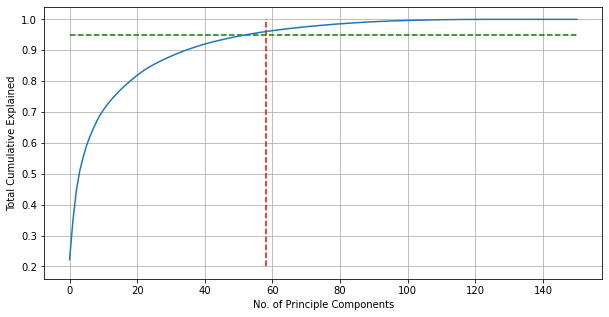

In [58]:
#use principal component analysis (PCA) for dimensionality reduction

pca = PCA(random_state=100)
pca.fit(X_train_scaled)

var_cumu = np.cumsum(pca.explained_variance_ratio_)
#plotting different variance for chosen no. of principle components
plt.figure(figsize=(10,5)) 
plt.vlines(x=58, ymax=1, ymin=0.2, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=150, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.xlabel('No. of Principle Components')
plt.ylabel('Total Cumulative Explained')
plt.grid()
plt.show()

In [59]:
pca_final = PCA(n_components=65, random_state=100)

In [60]:
df_train_pca = pca_final.fit_transform(X_train_scaled)
df_test_pca = pca_final.transform(X_test_scaled)

In [64]:
df_train_pca.shape, df_test_pca.shape

((62866, 65), (35000, 65))

In [104]:
models = [
    #DecisionTreeClassifier(max_depth=7),
    #RandomForestClassifier(max_depth=7, n_estimators=100, random_state=0),
    xgb.XGBClassifier(colsample_bytree = 0.837,max_depth=14, n_estimators=150, random_state= 5750, learning_rate=0.05,
                     min_child_weight = 3.0, reg_alpha = 1.37, reg_lambda = 0.87, subsample = 0.98),
    #ctb.CatBoostClassifier(max_depth=7, n_estimators=100, random_state=0, learning_rate=0.3, verbose=False)
]




pbar = tqdm(models)
for model in pbar:
    
    model_name = (str(model.__repr__).split("of")[-1].strip()
                  .split("(")[0].split(" ")[0].lower().replace("classifier", "")
                 )
    
    pbar.set_description(str(model_name))
    
    model.fit(df_train_pca, y_sm.values)
    y_pred = model.predict(df_test_pca)
    df_test["churn_probability"] = y_pred
    
    df_test[ ["id", "churn_probability"] ].to_csv("../output/{}_simple_1.csv".format(model_name), index=False)

xgb: 100%|██████████| 1/1 [02:58<00:00, 178.30s/it]


In [97]:
y_sm_array = y_sm.values

In [100]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    cv = StratifiedKFold(n_splits=3, shuffle = True, random_state = 0 )
    
    scores = []
    
    for train_idx, test_idx in  cv.split(df_train_pca,y_sm_array):
        
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(df_train_pca[train_idx], y_sm_array[train_idx])
        y_pred = model.predict(df_train_pca[test_idx])
        
        score = f1_score(y_sm_array[test_idx], y_pred.astype('int8'))
        scores.append(score)
    
        return{'loss':np.mean(scores), 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective, #funkcja optymalizacja zdefiniowana wyżej
            space=space, #przestrzeń potencjalnych (hyper)parametrów
            algo=partial(tpe.suggest, n_startup_jobs=1), #algorytm użyty to optymalizacji, tylko pierwsza iteracja jest losowa
            max_evals=20, #ilość prób
            trials=trials) #tu są zapisywane wyniki w trakcie, może przydać się później

print("The best params: ", best_params)

100%|██████████| 20/20 [24:10<00:00, 72.51s/trial, best loss: 0.17376906318082788]
The best params:  {'x_colsample_bytree': 0.8379893768557174, 'x_learning_rate': 0.050331868947362524, 'x_max_depth': 14.0, 'x_min_child_weight': 3.0, 'x_random_state': 5750.0, 'x_reg_alpha': 1.3743899307779912, 'x_reg_lambda': 0.8691872107489421, 'x_subsample': 0.9884783318441644}
